In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
  return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

In [4]:
xs = np.arange(-5, 5, 0.25)
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [5]:
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

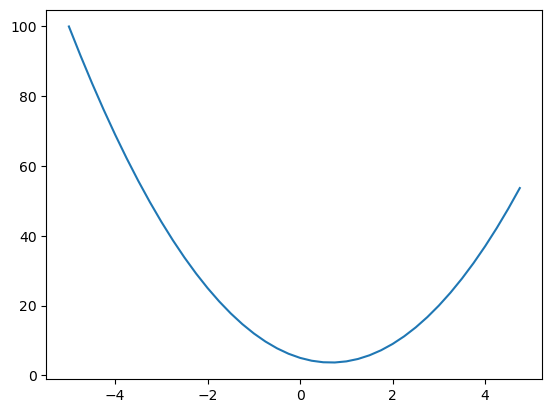

In [6]:
plt.plot(xs,ys)

In [7]:
h=0.001
x=2/3
(f(x+h)-f(x))/h

0.0029999999995311555

In [8]:
# les get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [9]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [40]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
      self.data = data
      self.grad = 0.0
      self._backward = lambda: None
      self._prev = set(_children)
      self._op = _op
      self.label = label

  def __repr__(self):
      return f"Value(data={self.data})"
  
  def __add__(self, other):
      other = other if isinstance(other, Value) else Value(other)
      out = Value(self.data + other.data, (self, other), '+')
    
      def _backward():
          self.grad += 1.0 * out.grad
          other.grad += 1.0 * out.grad
      out._backward = _backward
    
      return out

  def __mul__(self, other):
      other = other if isinstance(other, Value) else Value(other)
      out = Value(self.data * other.data, (self, other), '*')
    
      def _backward():
          self.grad += other.data * out.grad
          other.grad += self.data * out.grad
      out._backward = _backward
      
      return out
  
  def __pow__(self, other):
      assert isinstance(other, (int, float)), "only supporting int/float powers for now"
      out = Value(self.data**other, (self,), f'**{other}')

      def _backward():
          self.grad += other * (self.data ** (other - 1)) * out.grad
      out._backward = _backward

      return out
  
  def __rmul__(self, other): # other * self
       return self * other

  def __truediv__(self, other): # self / other
       return self * other**-1

  def __neg__(self): # -self
       return self * -1

  def __sub__(self, other): # self - other
       return self + (-other)

  def __radd__(self, other): # other + self
       return self + other
  
  def tanh(self):
      x = self.data
      t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
      out = Value(t, (self, ), 'tanh')
    
      def _backward():
          self.grad += (1 - t**2) * out.grad
      out._backward = _backward
    
      return out
    
  def exp(self):
      x = self.data
      out = Value(math.exp(x), (self, ), 'exp')
    
      def _backward():
          self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
      out._backward = _backward
    
      return out
    
  def relu(self):
      out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

      def _backward():
          self.grad += (out.data > 0) * out.grad
          out._backward = _backward

      return out
  
  def backward(self):
    
      topo = []
      visited = set()
      def build_topo(v):
          if v not in visited:
            visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)
      build_topo(self)
    
      self.grad = 1.0
      for node in reversed(topo):
          node._backward()


a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L


Value(data=-8.0)

In [11]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [12]:
!pip install graphviz

In [13]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [14]:
f.grad=4
d.grad=-2
c.grad=-2
e.grad=-2
a.grad=6
b.grad=-4

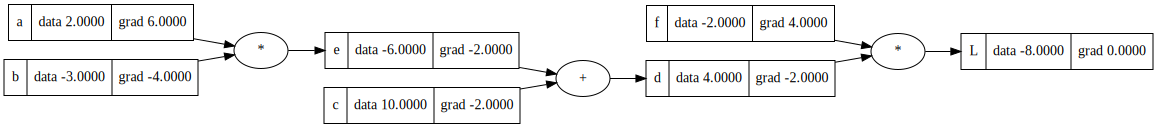

In [15]:
draw_dot(L)

In [16]:
L.grad=1


In [17]:
a.data+=0.01*a.grad
b.data+=0.01*b.grad
c.data+=0.01*c.grad
f.data+=0.01*f.grad

e = a*b
d = e + c
L = d * f
print(L.data)

-7.286496


In [18]:
def lol():
  
  h = 0.001
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data
  
  a = Value(2.0, label='a')
  a.data+=h
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data
  
  print((L2 - L1)/h)
  
lol()

6.000000000000227


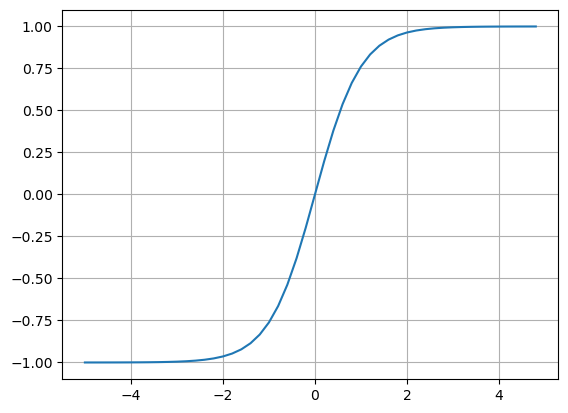

In [19]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [20]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [21]:
o.backward()

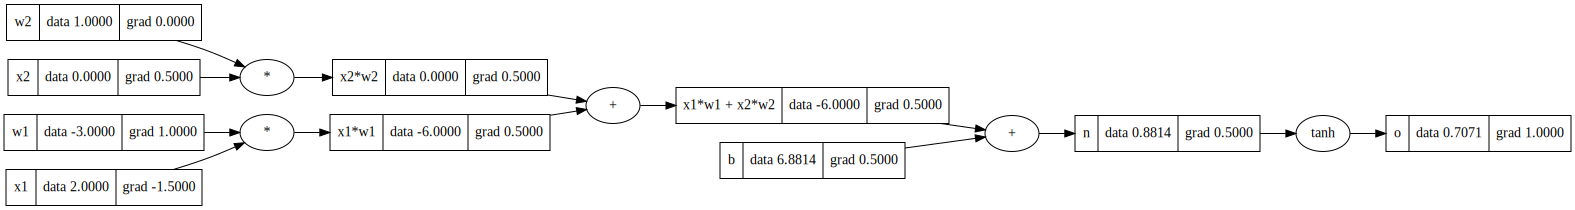

In [22]:
draw_dot(o)

In [23]:
n.tanh()

Value(data=0.7071067811865476)

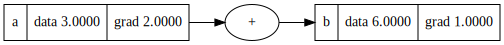

In [24]:
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

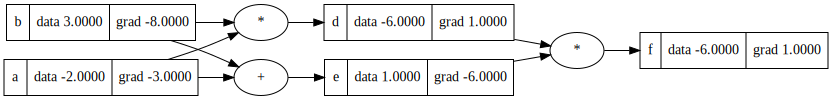

In [25]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

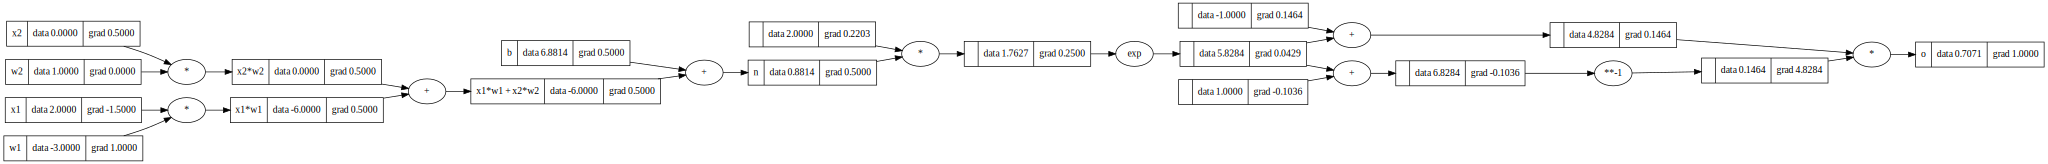

In [26]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
#-------------------
e = (2*n).exp()
o = (e - 1) / (e + 1)
#----------------------
o.label = 'o'
o.backward()
draw_dot(o)

In [27]:
import torch

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [28]:
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [29]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.2062976402029123)

In [30]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [31]:
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.2062976402029123),
 Value(data=-0.5464824295011669),
 Value(data=-0.08143779582383687),
 Value(data=-0.1732432123281237)]

In [32]:
loss=sum((yout-ygt)**2 for ygt,yout in zip(ys,ypred))
loss

Value(data=3.881088341725265)

In [33]:
loss.backward()

In [34]:
n.layers[0].neurons[0].w[0].grad

0.07336279642095575

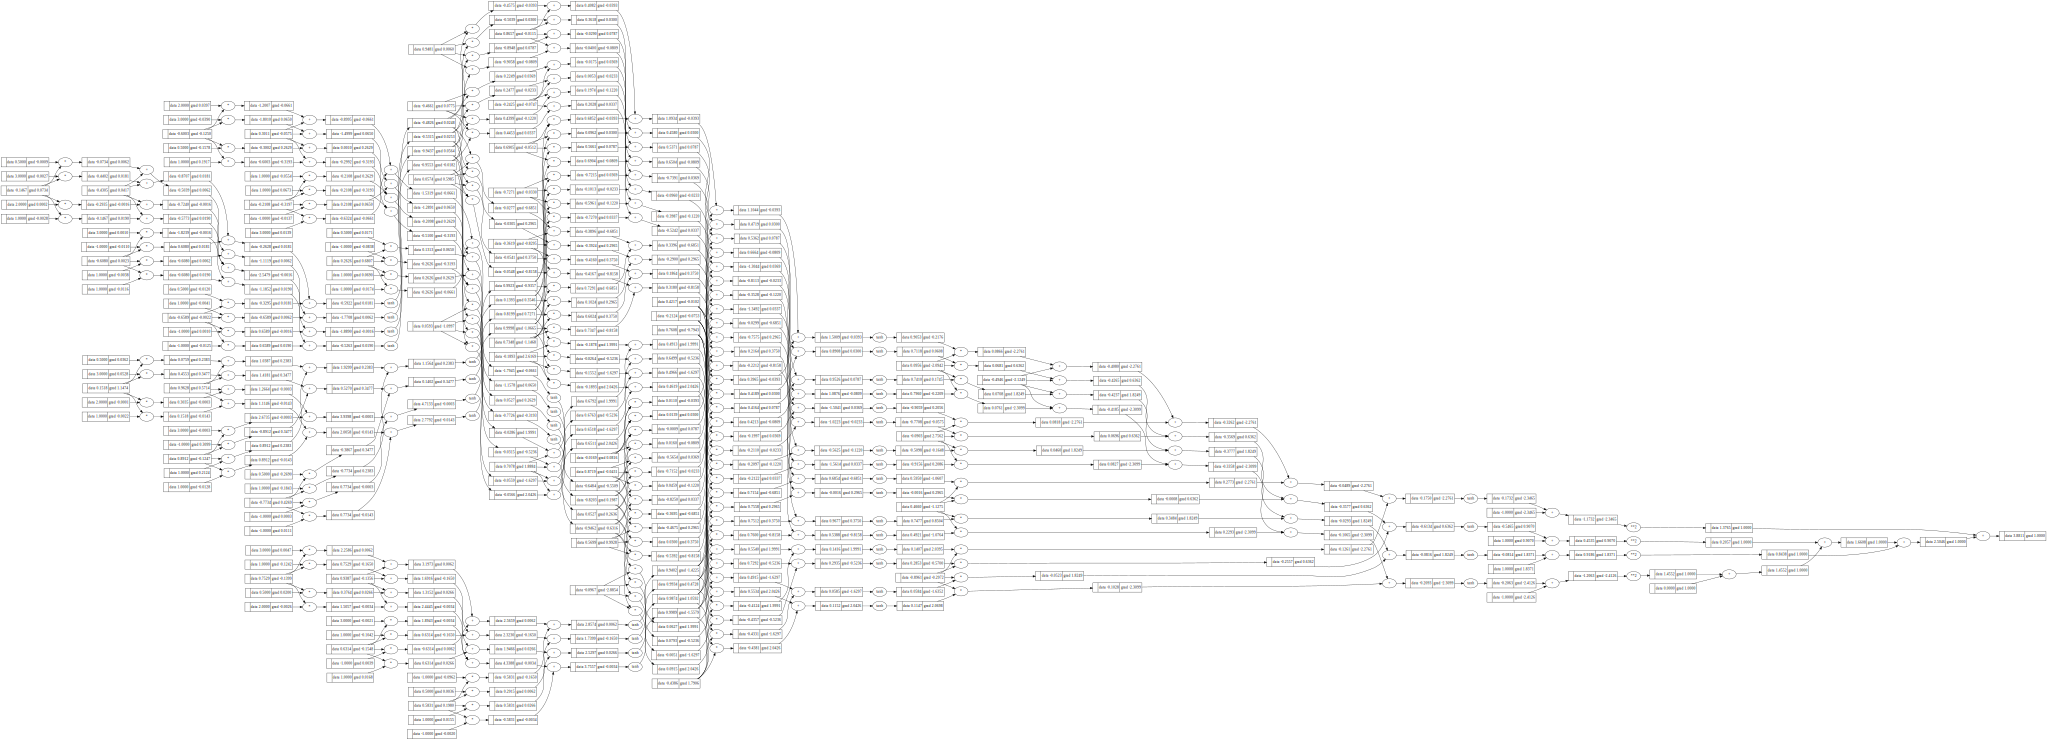

In [35]:
draw_dot(loss)

In [36]:
n.parameters()

[Value(data=-0.1467378432557631),
 Value(data=-0.60797790217031),
 Value(data=-0.6589173130453156),
 Value(data=-0.43052124529484415),
 Value(data=0.15176863250903483),
 Value(data=0.8911602185836733),
 Value(data=-0.7734484466486107),
 Value(data=0.9628234507039957),
 Value(data=-0.6003343424349128),
 Value(data=-0.21080228609132523),
 Value(data=0.2625825996238622),
 Value(data=0.30113131388768766),
 Value(data=0.7528728408069587),
 Value(data=0.631429912581219),
 Value(data=0.5830728129941345),
 Value(data=0.9387197950925072),
 Value(data=0.9481448820074989),
 Value(data=0.6904974567960223),
 Value(data=-0.016895891384369977),
 Value(data=0.42171229697339263),
 Value(data=0.8657464744908374),
 Value(data=-0.4661236282410435),
 Value(data=-0.7271046816605127),
 Value(data=0.8719027893391038),
 Value(data=-0.21241700193491964),
 Value(data=-0.2424723655597636),
 Value(data=0.05737808576264514),
 Value(data=0.734786856411157),
 Value(data=0.5698510256113405),
 Value(data=0.760846855107

In [37]:
  for p in n.parameters():
    p.data += -0.1 * p.grad

In [38]:
n.layers[0].neurons[0].w[0].data

-0.15407412289785868

In [39]:
for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)

0 4.751742060491019
1 2.8978422238137465
2 2.366890694069326
3 0.14698355211674374
4 0.06711622885545752
5 0.0481430658737831
6 0.03847395904902447
7 0.03243384750235126
8 0.02823079469505943
9 0.025100751121413287
10 0.022658600563532964
11 0.020687573716032224
12 0.0190555621423645
13 0.017677035091333726
14 0.016493912109404943
15 0.015465199903758782
16 0.014561027691695327
17 0.01375903959344841
18 0.013042120045136612
19 0.01239690799608652
